#  Face recognition with LeNet 

Step 1: Organize imports

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split  
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical  
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.models import Sequential, model_from_json  
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense

In [2]:
import numpy as np  
import os  
import sys 
import argparse 
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import cv2

In [4]:
plt.rcParams["figure.figsize"] = (20,10)

In [5]:
NB_EPOCH = 200
BATCH_SIZE = 128
VERBOSE = 1
OPTIMIZER = Adam()
VALIDATION_SPLIT=0.2

IMG_ROWS, IMG_COLS = 28, 28 
NB_CLASSES = 10  
INPUT_SHAPE = (1, IMG_ROWS, IMG_COLS)

np.random.seed(1983)  # for reproducibility
K.set_image_data_format("channels_first")

Step 2: Define method to load images from subfolders of category

In [6]:
def load_images_from_folders(folders, root_dir):
    print('Acquiring images...')
    images = []
    labels = []
    for folder in folders:        
        for filename in os.listdir(os.path.join(root_dir,folder)):
            if any([filename.endswith(x) for x in ['.jpeg', '.jpg','.pgm','png']]):
                img = cv2.imread(os.path.join(root_dir, folder, filename), cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    image = cv2.resize(img, (IMG_COLS, IMG_ROWS)) 
                    image = np.array(image, 'uint8') # convert to numpy array
                    images.append(image)
                    label = os.path.split(folder)[1].split("_")[1] # number from person_0_
                    labels.append(label)
    return images, labels;

Step 3: Load images from subfolders of category: 10 persons; 50 images each

In [7]:
folders = [
    'person_0_abad',
    'person_1_agui',
    'person_2_cans',
    'person_3_degu',
    'person_4_hato',
    'person_5_libb',
    'person_6_palo',
    'person_7_prim',
    'person_8_rosa',
    'person_9_venu'
]

root_dir = r'./front_database'

(images, labels) = load_images_from_folders(folders, root_dir)
print('No. of images = %s. ' %  len(images))
print('No. of labels = %s. ' %  len(labels))
print(labels[0])

Acquiring images...
No. of images = 500. 
No. of labels = 500. 
0


Step 4: Plot the first image.

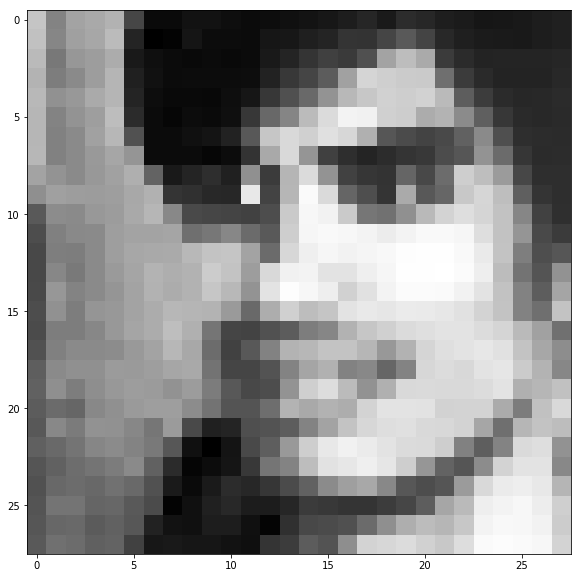

In [10]:
plt.imshow(images[0], cmap='gray')

Step 5: Define method for plotting a person: 50 images 

In [11]:
def plot_person_category(images, id):
    for k in range(50*id,50*id + 50):
        plt.subplot(5, 10, k - (50*id - 1))      
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.imshow(images[k], cmap='gray')

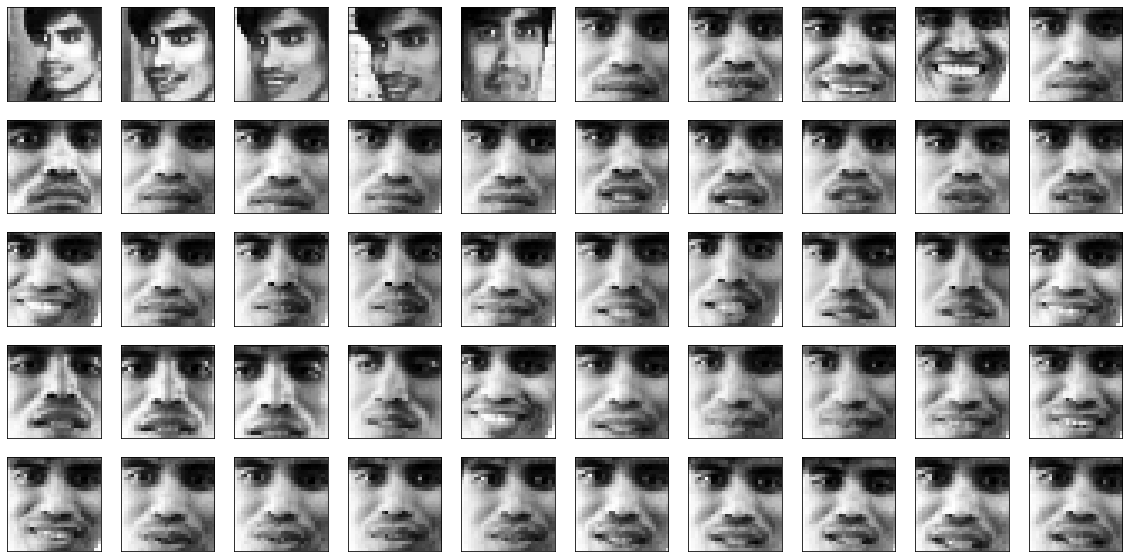

In [12]:
# Plot person 0
plot_person_category(images, 0)

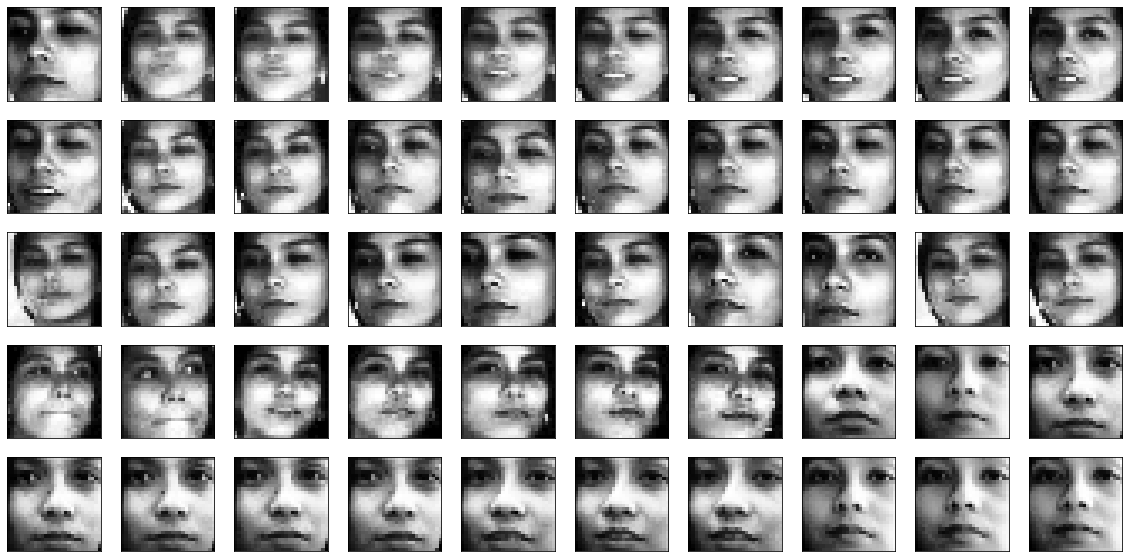

In [10]:
# Plot person 1
plot_person_category(images, 1)

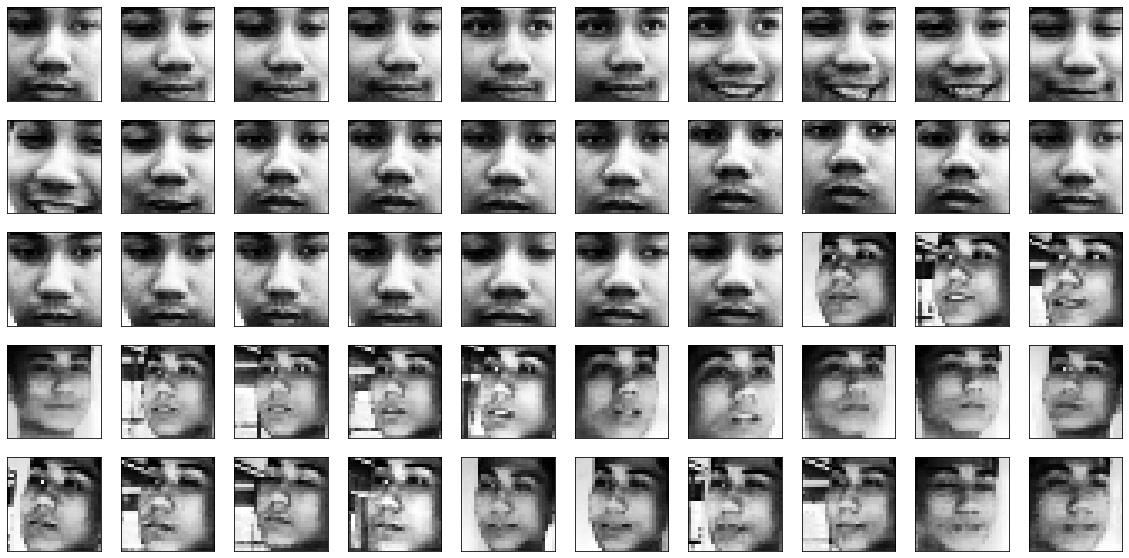

In [11]:
# Plot person 2
plot_person_category(images, 2)

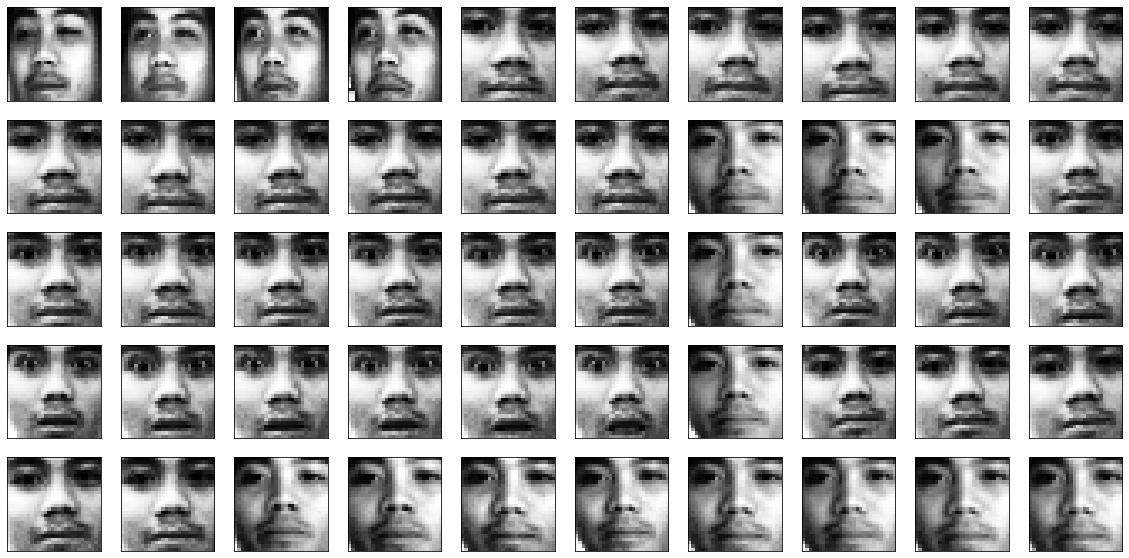

In [12]:
# Plot person 3
plot_person_category(images, 3)

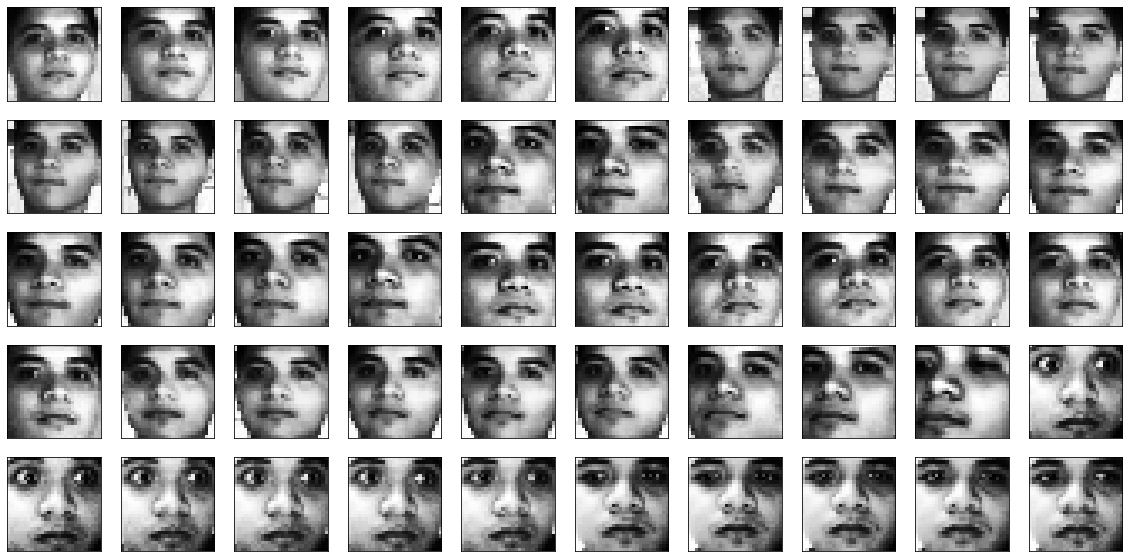

In [13]:
# Plot person 4
plot_person_category(images, 4)

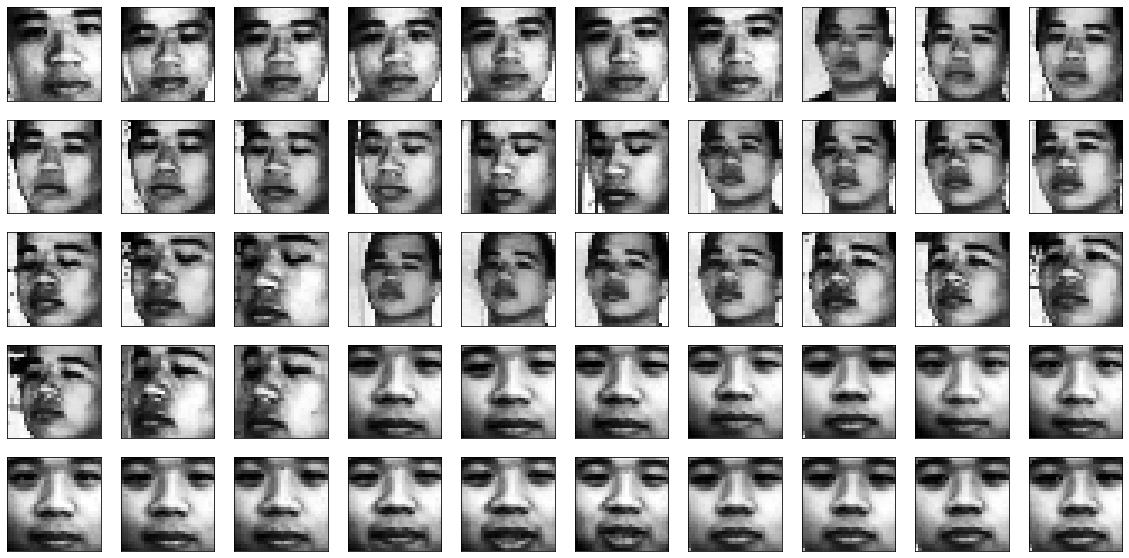

In [14]:
# Plot person 5
plot_person_category(images, 5)

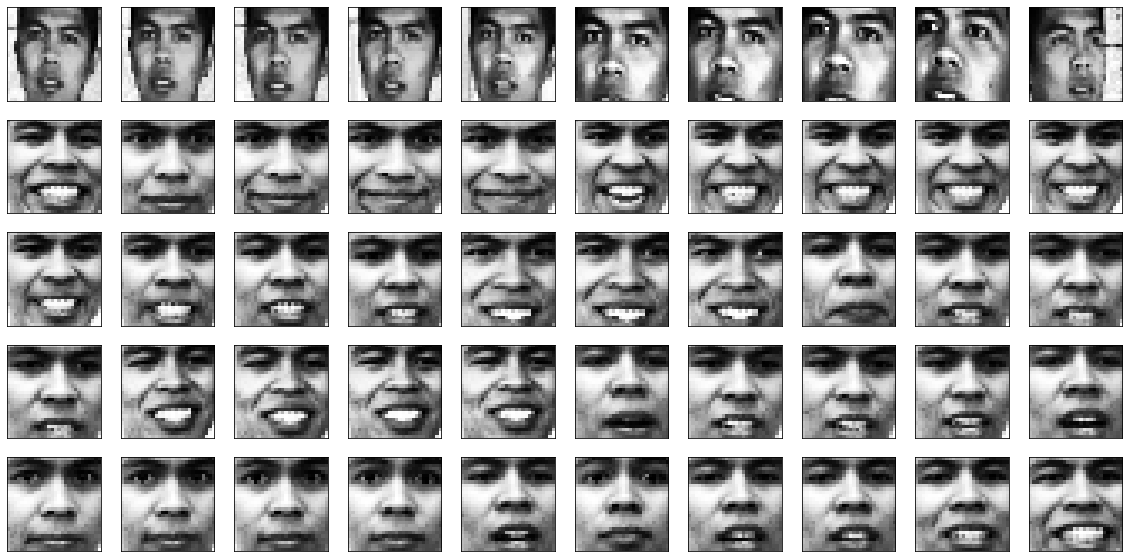

In [15]:
# Plot person 6
plot_person_category(images, 6)

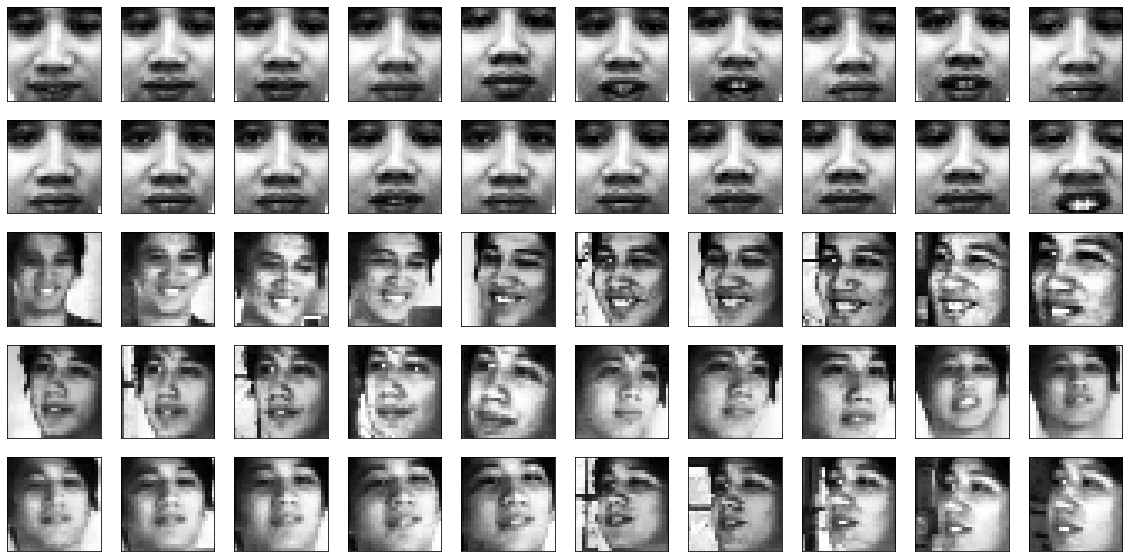

In [16]:
# Plot person 7
plot_person_category(images, 7)

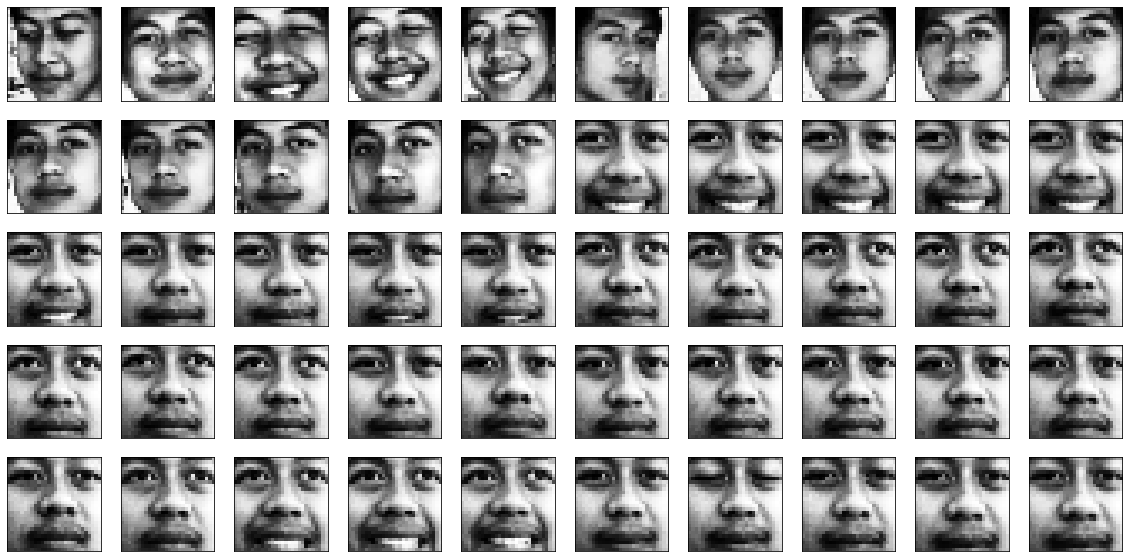

In [17]:
# Plot person 8
plot_person_category(images, 8)

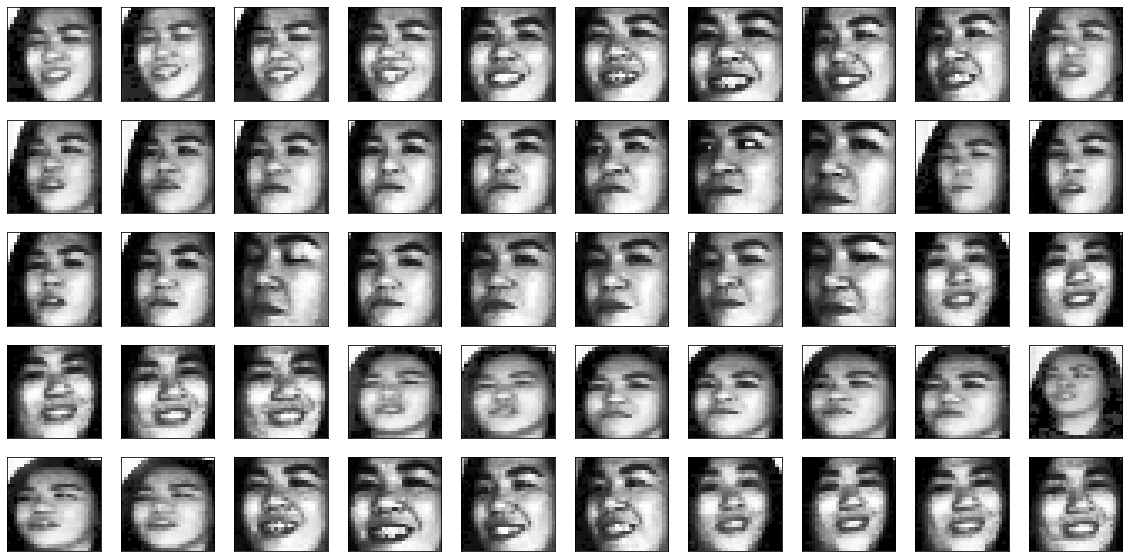

In [18]:
# Plot person 9
plot_person_category(images, 9)

Separate into test and train

In [8]:
(trainData, testData, trainLabels, testLabels) = train_test_split(images, labels, test_size=0.10)

One-Hot Encoding

In [9]:
print('Before: trainLabels[0] = %s' % trainLabels[0])
print('Before: testLabels[0] = %s' % testLabels[0])
trainLabels = to_categorical(trainLabels, NB_CLASSES)  
testLabels = to_categorical(testLabels, NB_CLASSES) 
print('After: trainLabels[0] = %s' % trainLabels[0])
print('After: testLabels[0] = %s' % testLabels[0])

Before: trainLabels[0] = 9
Before: testLabels[0] = 4
After: trainLabels[0] = [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
After: testLabels[0] = [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [10]:
class LeNet:
	@staticmethod
	def build(input_shape, classes):
		model = Sequential()
		# CONV => RELU => POOL
		model.add(Conv2D(20, kernel_size=5, padding="same",
			input_shape=input_shape))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),data_format='channels_first'))
		# CONV => RELU => POOL
		model.add(Conv2D(50, kernel_size=5, padding="same"))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),data_format='channels_first'))
		# Flatten => RELU layers
		model.add(Flatten())
		model.add(Dense(500))
		model.add(Activation("relu"))
 
		# a softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		return model

In [11]:
# Convert to NumPy array
trainData = np.asarray(trainData)  
testData = np.asarray(testData)  

# Convert uint to float32
trainData = trainData.astype('float32')
testData = testData.astype('float32')

# Normalize
trainData /= 255 
testData /= 255

# No. of Samples x [1 x 28 x 28] shape as input to the CONVNET
trainData = trainData[:, np.newaxis, :, :]
testData = testData[:, np.newaxis, :, :]

print(trainData.shape, 'train samples')
print(testData.shape, 'test samples')

(450, 1, 28, 28) train samples
(50, 1, 28, 28) test samples


In [12]:
model = LeNet.build(input_shape=INPUT_SHAPE, classes=NB_CLASSES)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 28, 28)        520       
_________________________________________________________________
activation (Activation)      (None, 20, 28, 28)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 14, 14)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 14, 14)        25050     
_________________________________________________________________
activation_1 (Activation)    (None, 50, 14, 14)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 7, 7)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2450)              0

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer=OPTIMIZER,
              metrics=['accuracy'])

In [14]:
history = model.fit(trainData, trainLabels,
                    batch_size=BATCH_SIZE, epochs=NB_EPOCH,
                    verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

Train on 360 samples, validate on 90 samples
Epoch 1/200
360/360 [==============================] - 2s 7ms/sample - loss: 2.2851 - accuracy: 0.1861 - val_loss: 2.1572 - val_accuracy: 0.3889
Epoch 2/200
360/360 [==============================] - 0s 179us/sample - loss: 2.0375 - accuracy: 0.3611 - val_loss: 1.8373 - val_accuracy: 0.4889
Epoch 3/200
360/360 [==============================] - 0s 174us/sample - loss: 1.7082 - accuracy: 0.5028 - val_loss: 1.5372 - val_accuracy: 0.4889
Epoch 4/200
360/360 [==============================] - 0s 168us/sample - loss: 1.4102 - accuracy: 0.5528 - val_loss: 1.3977 - val_accuracy: 0.5111
Epoch 5/200
360/360 [==============================] - 0s 158us/sample - loss: 1.2041 - accuracy: 0.5917 - val_loss: 1.3003 - val_accuracy: 0.6444
Epoch 6/200
360/360 [==============================] - 0s 179us/sample - loss: 1.1497 - accuracy: 0.6083 - val_loss: 1.2021 - val_accuracy: 0.6111
Epoch 7/200
360/360 [==============================] - 0s 180us/sample - lo

360/360 [==============================] - 0s 182us/sample - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.2297 - val_accuracy: 0.9556
Epoch 57/200
360/360 [==============================] - 0s 165us/sample - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2336 - val_accuracy: 0.9667
Epoch 58/200
360/360 [==============================] - 0s 171us/sample - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2317 - val_accuracy: 0.9667
Epoch 59/200
360/360 [==============================] - 0s 176us/sample - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2280 - val_accuracy: 0.9556
Epoch 60/200
360/360 [==============================] - 0s 168us/sample - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2277 - val_accuracy: 0.9556
Epoch 61/200
360/360 [==============================] - 0s 178us/sample - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.2340 - val_accuracy: 0.9667
Epoch 62/200
360/360 [==============================] - 0s 174us/sample - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.2333 

360/360 [==============================] - 0s 174us/sample - loss: 5.5135e-04 - accuracy: 1.0000 - val_loss: 0.2414 - val_accuracy: 0.9667
Epoch 111/200
360/360 [==============================] - 0s 198us/sample - loss: 5.4207e-04 - accuracy: 1.0000 - val_loss: 0.2409 - val_accuracy: 0.9667
Epoch 112/200
360/360 [==============================] - 0s 178us/sample - loss: 5.3186e-04 - accuracy: 1.0000 - val_loss: 0.2419 - val_accuracy: 0.9667
Epoch 113/200
360/360 [==============================] - 0s 167us/sample - loss: 5.2348e-04 - accuracy: 1.0000 - val_loss: 0.2441 - val_accuracy: 0.9667
Epoch 114/200
360/360 [==============================] - 0s 172us/sample - loss: 5.1855e-04 - accuracy: 1.0000 - val_loss: 0.2461 - val_accuracy: 0.9667
Epoch 115/200
360/360 [==============================] - 0s 180us/sample - loss: 5.0657e-04 - accuracy: 1.0000 - val_loss: 0.2444 - val_accuracy: 0.9667
Epoch 116/200
360/360 [==============================] - 0s 169us/sample - loss: 4.9762e-04 - ac

360/360 [==============================] - 0s 180us/sample - loss: 2.6309e-04 - accuracy: 1.0000 - val_loss: 0.2510 - val_accuracy: 0.9667
Epoch 164/200
360/360 [==============================] - 0s 175us/sample - loss: 2.5906e-04 - accuracy: 1.0000 - val_loss: 0.2499 - val_accuracy: 0.9667
Epoch 165/200
360/360 [==============================] - 0s 187us/sample - loss: 2.5610e-04 - accuracy: 1.0000 - val_loss: 0.2493 - val_accuracy: 0.9667
Epoch 166/200
360/360 [==============================] - 0s 175us/sample - loss: 2.5346e-04 - accuracy: 1.0000 - val_loss: 0.2498 - val_accuracy: 0.9667
Epoch 167/200
360/360 [==============================] - 0s 198us/sample - loss: 2.5074e-04 - accuracy: 1.0000 - val_loss: 0.2498 - val_accuracy: 0.9667
Epoch 168/200
360/360 [==============================] - 0s 177us/sample - loss: 2.4745e-04 - accuracy: 1.0000 - val_loss: 0.2498 - val_accuracy: 0.9667
Epoch 169/200
360/360 [==============================] - 0s 176us/sample - loss: 2.4488e-04 - ac

In [15]:
score = model.evaluate(testData, testLabels, verbose=VERBOSE)
print("\nTest score:", score[0])
print('Test accuracy:', score[1])

50/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


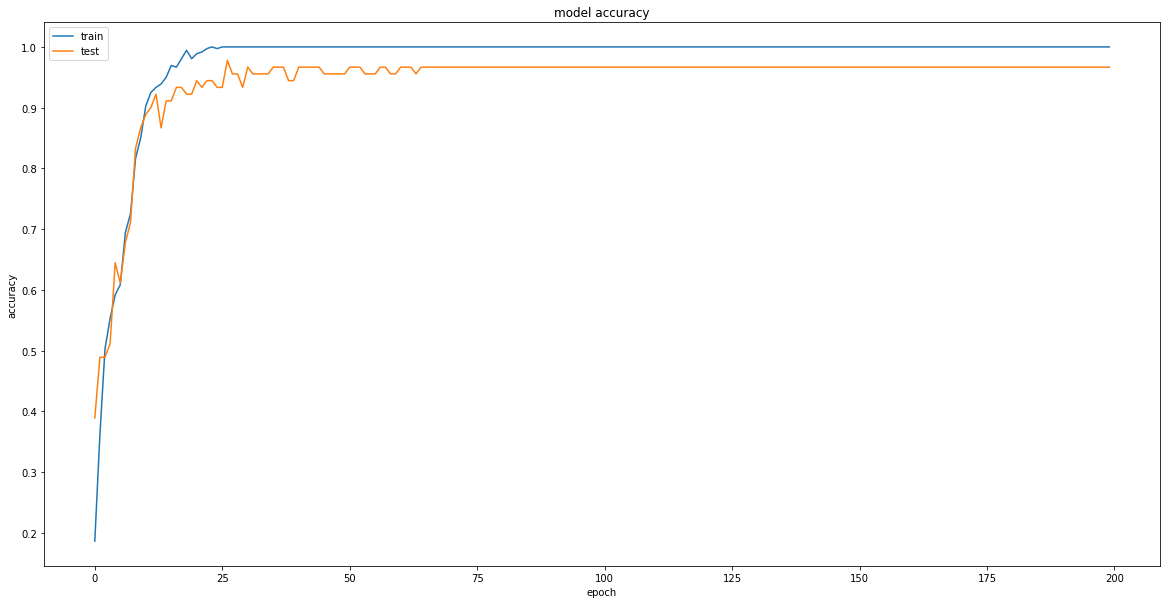

In [18]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

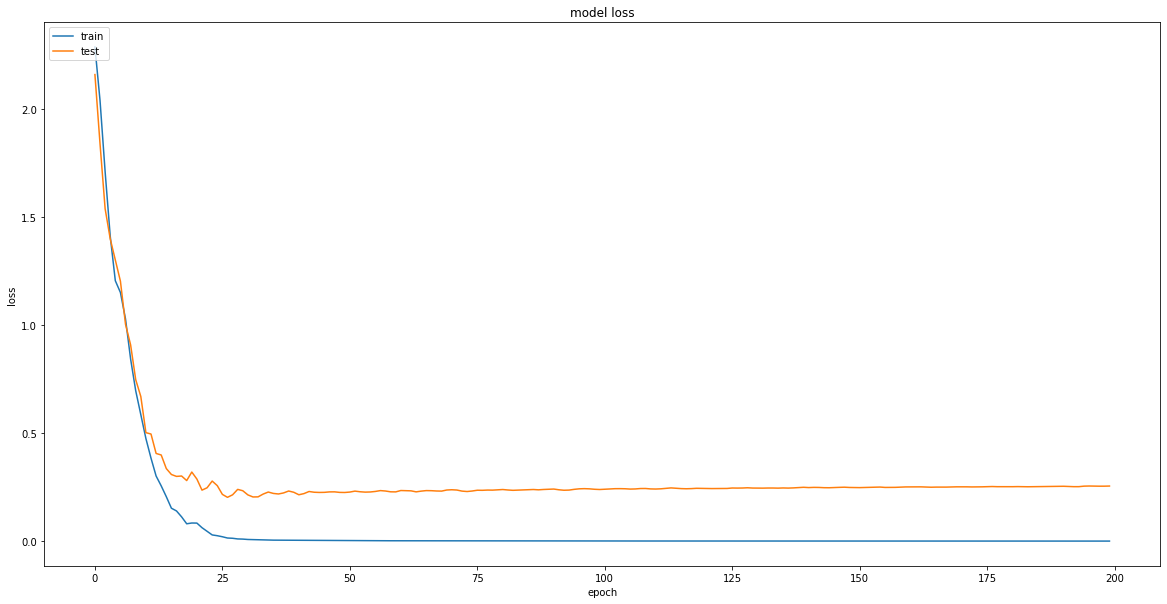

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
%ls

FaceRecognitionLeNet.ipynb      model.h5      ReadMultipleImages.ipynb
FaceRecognitionLeNetv2.ipynb    model.json    side_database/
FaceRecognitionSimpleCNN.ipynb  modelv2.h5
front_database/                 modelv2.json


In [20]:
model.save_weights("model.h5")
%ls

FaceRecognitionLeNet.ipynb      model.h5      ReadMultipleImages.ipynb
FaceRecognitionLeNetv2.ipynb    model.json    side_database/
FaceRecognitionSimpleCNN.ipynb  modelv2.h5
front_database/                 modelv2.json


In [21]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model.h5")

In [22]:
loaded_model.compile(loss='categorical_crossentropy',
              optimizer=OPTIMIZER,
              metrics=['accuracy'])
score = loaded_model.evaluate(testData, testLabels, verbose=VERBOSE)
print("\nTest score:", score[0])
print('Test accuracy:', score[1])

50/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================